# 🤖 Modèle Simple - TF-IDF + Logistic Regression

Ce notebook entraîne un modèle de classification simple pour la détection de toxicité.

## Objectifs
- 📊 Vectoriser les textes avec TF-IDF
- 🤖 Entraîner Logistic Regression (baseline)
- 📈 Évaluer les performances
- 💾 Sauvegarder le modèle

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import time
from datetime import datetime

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, accuracy_score
)

import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("📦 Imports terminés !")
print(f"🕐 Démarrage: {datetime.now().strftime('%H:%M:%S')}")

📦 Imports terminés !
🕐 Démarrage: 12:46:50


## 1. 📁 Chargement des Données Préprocessées

In [2]:
# Chargement des données préprocessées
print("📊 Chargement des données préprocessées...")

train_df = pd.read_csv('../data/train_preprocessed.csv')
test_df = pd.read_csv('../data/test_preprocessed.csv')

print(f"✅ Train: {train_df.shape[0]:,} lignes, {train_df.shape[1]} colonnes")
print(f"✅ Test: {test_df.shape[0]:,} lignes, {test_df.shape[1]} colonnes")

# Vérifier les colonnes importantes
required_cols = ['comment_clean', 'is_toxic']
for col in required_cols:
    if col in train_df.columns:
        print(f"✅ Colonne '{col}' présente")
    else:
        print(f"❌ Colonne '{col}' manquante")

# Distribution des labels
if 'is_toxic' in train_df.columns:
    toxic_count = train_df['is_toxic'].sum()
    total_count = len(train_df)
    print(f"\n📊 Distribution is_toxic:")
    print(f"  Toxic: {toxic_count:,} ({toxic_count/total_count*100:.1f}%)")
    print(f"  Non-toxic: {total_count-toxic_count:,} ({(total_count-toxic_count)/total_count*100:.1f}%)")

📊 Chargement des données préprocessées...
✅ Train: 20,000 lignes, 22 colonnes
✅ Test: 20,000 lignes, 13 colonnes
✅ Colonne 'comment_clean' présente
✅ Colonne 'is_toxic' présente

📊 Distribution is_toxic:
  Toxic: 2,060 (10.3%)
  Non-toxic: 17,940 (89.7%)


## 2. 🔧 Préparation des Données pour l'Entraînement

In [3]:
# Préparer les données d'entraînement
print("🔧 Préparation des données...")

# Textes et labels
X_train_text = train_df['comment_clean'].fillna('').astype(str)
y_train = train_df['is_toxic'].fillna(0).astype(int)

# Test (pas de labels dans notre cas)
X_test_text = test_df['comment_clean'].fillna('').astype(str) if 'comment_clean' in test_df.columns else None

print(f"📝 Textes d'entraînement: {len(X_train_text):,}")
print(f"🎯 Labels d'entraînement: {len(y_train):,}")

# Split train/validation (80/20)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_text, y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)

print(f"\n📊 Split train/validation:")
print(f"  Train: {len(X_train_split):,} textes")
print(f"  Validation: {len(X_val_split):,} textes")
print(f"  Train toxic: {y_train_split.sum():,} ({y_train_split.sum()/len(y_train_split)*100:.1f}%)")
print(f"  Val toxic: {y_val_split.sum():,} ({y_val_split.sum()/len(y_val_split)*100:.1f}%)")

🔧 Préparation des données...
📝 Textes d'entraînement: 20,000
🎯 Labels d'entraînement: 20,000

📊 Split train/validation:
  Train: 16,000 textes
  Validation: 4,000 textes
  Train toxic: 1,648 (10.3%)
  Val toxic: 412 (10.3%)


## 3. 📊 Vectorisation TF-IDF

In [4]:
# Configuration TF-IDF
print("📊 Configuration et entraînement TF-IDF...")

tfidf = TfidfVectorizer(
    max_features=10000,        # Limiter le vocabulaire
    min_df=2,                  # Ignorer mots très rares (< 2 occurrences)
    max_df=0.95,               # Ignorer mots très fréquents (> 95%)
    stop_words='english',      # Supprimer mots vides anglais
    ngram_range=(1, 2),        # Unigrammes + bigrammes
    lowercase=True,            # Déjà fait mais sécurité
    sublinear_tf=True         # Normalisation log des fréquences
)

# Entraîner et transformer
start_time = time.time()
X_train_tfidf = tfidf.fit_transform(X_train_split)
X_val_tfidf = tfidf.transform(X_val_split)
vectorization_time = time.time() - start_time

print(f"✅ TF-IDF terminé en {vectorization_time:.2f}s")
print(f"📏 Shape train: {X_train_tfidf.shape}")
print(f"📏 Shape validation: {X_val_tfidf.shape}")
print(f"🔤 Vocabulaire: {len(tfidf.vocabulary_):,} mots")
print(f"💾 Densité matrice: {X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]) * 100:.2f}%")

📊 Configuration et entraînement TF-IDF...
✅ TF-IDF terminé en 3.52s
📏 Shape train: (16000, 10000)
📏 Shape validation: (4000, 10000)
🔤 Vocabulaire: 10,000 mots
💾 Densité matrice: 0.25%
✅ TF-IDF terminé en 3.52s
📏 Shape train: (16000, 10000)
📏 Shape validation: (4000, 10000)
🔤 Vocabulaire: 10,000 mots
💾 Densité matrice: 0.25%


In [5]:
# Analyser les mots les plus importants
print("🔍 Analyse du vocabulaire TF-IDF...")

# Top mots par TF-IDF moyen
feature_names = tfidf.get_feature_names_out()
mean_tfidf = np.array(X_train_tfidf.mean(axis=0)).flatten()
top_indices = mean_tfidf.argsort()[-20:][::-1]

print("\n🔥 Top 20 mots par TF-IDF moyen:")
for i, idx in enumerate(top_indices):
    print(f"  {i+1:2d}. {feature_names[idx]:15} ({mean_tfidf[idx]:.4f})")

🔍 Analyse du vocabulaire TF-IDF...

🔥 Top 20 mots par TF-IDF moyen:
   1. organization    (0.0388)
   2. person          (0.0371)
   3. article         (0.0202)
   4. talk            (0.0197)
   5. location        (0.0190)
   6. page            (0.0186)
   7. just            (0.0146)
   8. like            (0.0135)
   9. don             (0.0127)
  10. thanks          (0.0123)
  11. address         (0.0112)
  12. know            (0.0110)
  13. think           (0.0110)
  14. ip              (0.0108)
  15. ip address      (0.0104)
  16. edit            (0.0103)
  17. did             (0.0091)
  18. people          (0.0087)
  19. user            (0.0087)
  20. time            (0.0086)


## 4. 🤖 Entraînement des Modèles

In [6]:
# Dictionnaire pour stocker les résultats
models_results = {}

def train_and_evaluate_model(model, model_name, X_train, X_val, y_train, y_val):
    """Entraîne et évalue un modèle"""
    print(f"\n🤖 Entraînement {model_name}...")
    
    # Entraînement
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Prédictions
    start_time = time.time()
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None
    inference_time = time.time() - start_time
    
    # Métriques
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else None
    
    # Stocker les résultats
    results = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'auc_roc': auc,
        'train_time': train_time,
        'inference_time': inference_time,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"  ✅ Entraînement: {train_time:.2f}s")
    print(f"  ⚡ Inférence: {inference_time:.2f}s ({inference_time/len(y_val)*1000:.2f}ms/texte)")
    print(f"  📊 Accuracy: {accuracy:.4f}")
    print(f"  📊 F1-Score: {f1:.4f}")
    if auc:
        print(f"  📊 AUC-ROC: {auc:.4f}")
    
    return results

print("🚀 Début de l'entraînement des modèles...")

🚀 Début de l'entraînement des modèles...


In [7]:
# 1. Logistic Regression
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Gérer le déséquilibre des classes
)

models_results['Logistic Regression'] = train_and_evaluate_model(
    lr_model, 'Logistic Regression', 
    X_train_tfidf, X_val_tfidf, y_train_split, y_val_split
)


🤖 Entraînement Logistic Regression...
  ✅ Entraînement: 0.34s
  ⚡ Inférence: 0.01s (0.00ms/texte)
  📊 Accuracy: 0.9350
  📊 F1-Score: 0.7124
  📊 AUC-ROC: 0.9515
  ✅ Entraînement: 0.34s
  ⚡ Inférence: 0.01s (0.00ms/texte)
  📊 Accuracy: 0.9350
  📊 F1-Score: 0.7124
  📊 AUC-ROC: 0.9515


In [8]:
# 2. Naive Bayes
nb_model = MultinomialNB(alpha=0.1)  # Lissage de Laplace

models_results['Naive Bayes'] = train_and_evaluate_model(
    nb_model, 'Naive Bayes',
    X_train_tfidf, X_val_tfidf, y_train_split, y_val_split
)


🤖 Entraînement Naive Bayes...
  ✅ Entraînement: 0.03s
  ⚡ Inférence: 0.03s (0.01ms/texte)
  📊 Accuracy: 0.9440
  📊 F1-Score: 0.6564
  📊 AUC-ROC: 0.9408


In [9]:
# 3. Random Forest (plus lent mais souvent efficace)
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1  # Parallélisation
)

models_results['Random Forest'] = train_and_evaluate_model(
    rf_model, 'Random Forest',
    X_train_tfidf, X_val_tfidf, y_train_split, y_val_split
)


🤖 Entraînement Random Forest...
  ✅ Entraînement: 9.82s
  ⚡ Inférence: 0.39s (0.10ms/texte)
  📊 Accuracy: 0.9395
  📊 F1-Score: 0.6171
  📊 AUC-ROC: 0.9326
  ✅ Entraînement: 9.82s
  ⚡ Inférence: 0.39s (0.10ms/texte)
  📊 Accuracy: 0.9395
  📊 F1-Score: 0.6171
  📊 AUC-ROC: 0.9326


## 5. 📊 Comparaison des Modèles

In [10]:
# Tableau comparatif
print("📊 TABLEAU COMPARATIF DES MODÈLES")
print("=" * 80)

comparison_data = []
for name, results in models_results.items():
    comparison_data.append({
        'Modèle': name,
        'Accuracy': f"{results['accuracy']:.4f}",
        'F1-Score': f"{results['f1_score']:.4f}",
        'AUC-ROC': f"{results['auc_roc']:.4f}" if results['auc_roc'] else 'N/A',
        'Temps Entraînement (s)': f"{results['train_time']:.2f}",
        'Temps Inférence (ms/texte)': f"{results['inference_time']/len(y_val_split)*1000:.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Identifier le meilleur modèle par F1-Score
best_model_name = max(models_results.keys(), key=lambda x: models_results[x]['f1_score'])
print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")
print(f"   F1-Score: {models_results[best_model_name]['f1_score']:.4f}")
print(f"   Critère validé: {'✅' if models_results[best_model_name]['f1_score'] > 0.75 else '❌'} F1 > 0.75")
print(f"   Temps inférence: {models_results[best_model_name]['inference_time']/len(y_val_split)*1000:.2f}ms/texte")
print(f"   Critère validé: {'✅' if (models_results[best_model_name]['inference_time']/len(y_val_split)*1000) < 500 else '❌'} < 500ms")

📊 TABLEAU COMPARATIF DES MODÈLES


,Modèle,Accuracy,F1-Score,AUC-ROC,Temps Entraînement (s),Temps Inférence (ms/texte)
0,Logistic Regression,0.9350,0.7124,0.9515,0.34,0.00
1,Naive Bayes,0.9440,0.6564,0.9408,0.03,0.01
2,Random Forest,0.9395,0.6171,0.9326,9.82,0.10



🏆 MEILLEUR MODÈLE: Logistic Regression
   F1-Score: 0.7124
   Critère validé: ❌ F1 > 0.75
   Temps inférence: 0.00ms/texte
   Critère validé: ✅ < 500ms


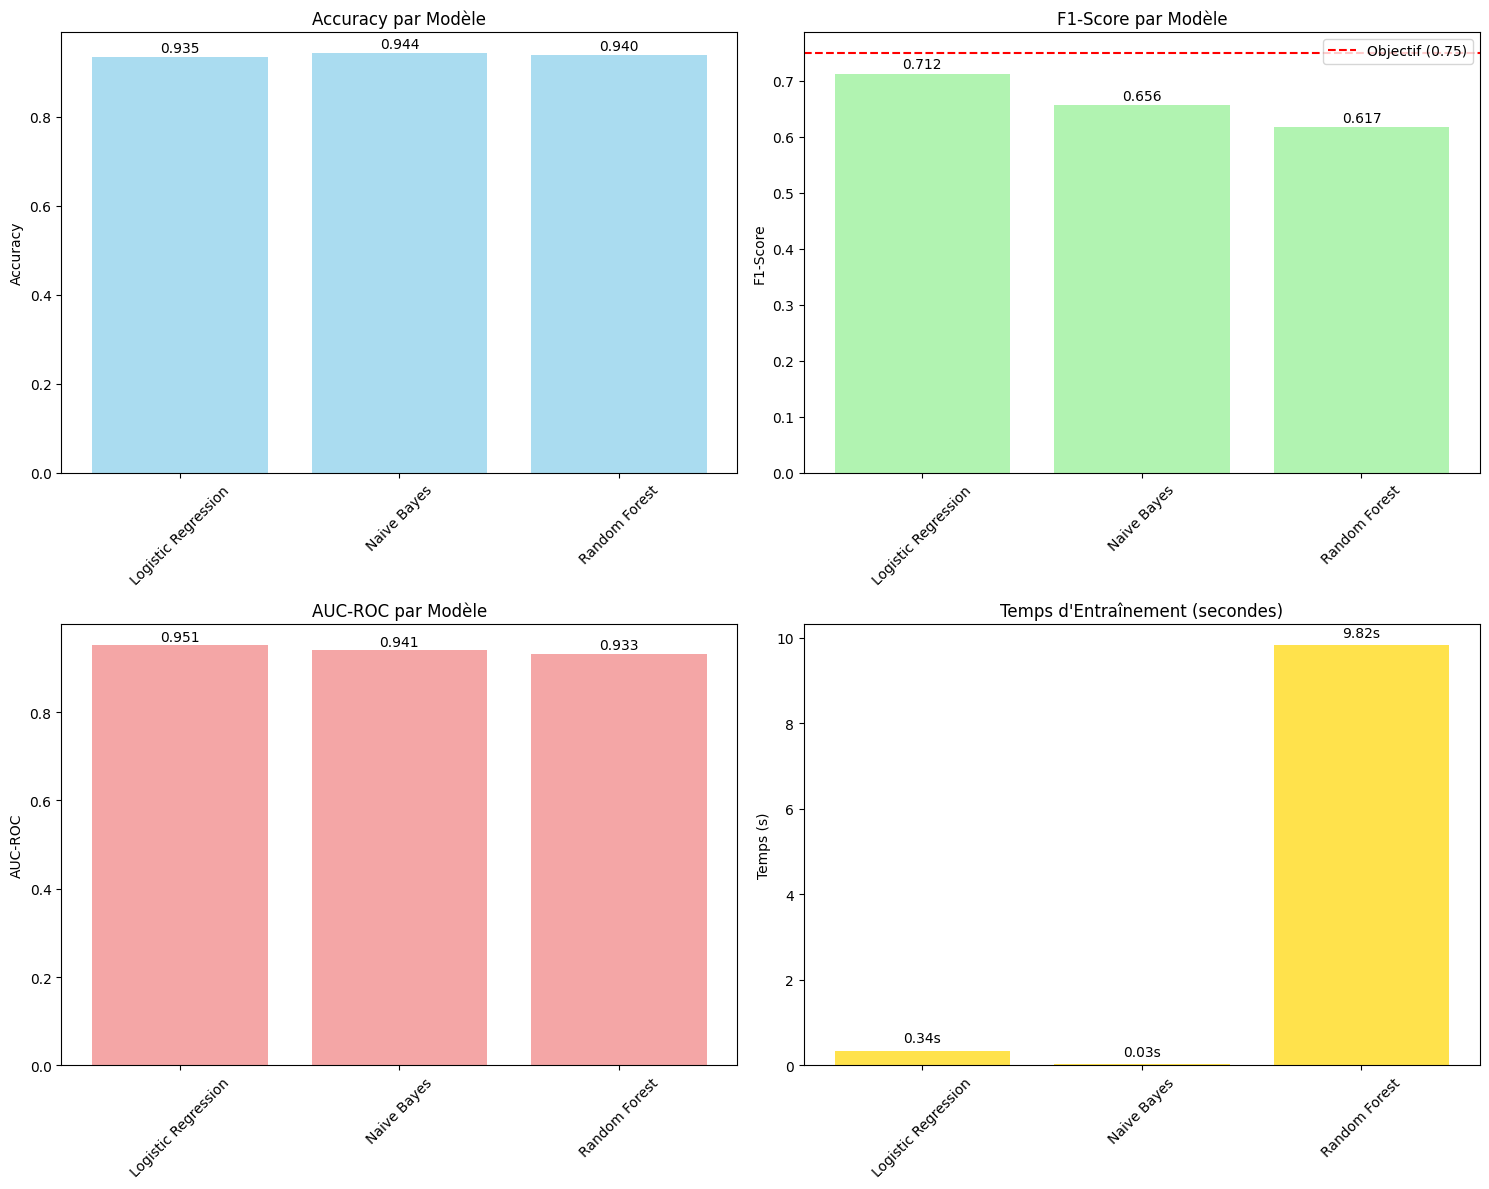

In [11]:
# Visualisations comparatives
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Métriques
models = list(models_results.keys())
accuracies = [models_results[m]['accuracy'] for m in models]
f1_scores = [models_results[m]['f1_score'] for m in models]
auc_scores = [models_results[m]['auc_roc'] for m in models if models_results[m]['auc_roc']]
train_times = [models_results[m]['train_time'] for m in models]

# 1. Accuracy
axes[0,0].bar(models, accuracies, color='skyblue', alpha=0.7)
axes[0,0].set_title('Accuracy par Modèle')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(accuracies):
    axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# 2. F1-Score
axes[0,1].bar(models, f1_scores, color='lightgreen', alpha=0.7)
axes[0,1].set_title('F1-Score par Modèle')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(y=0.75, color='red', linestyle='--', label='Objectif (0.75)')
axes[0,1].legend()
for i, v in enumerate(f1_scores):
    axes[0,1].text(i, v + 0.01, f'{v:.3f}', ha='center')

# 3. AUC-ROC (si disponible)
if len(auc_scores) == len(models):
    axes[1,0].bar(models, auc_scores, color='lightcoral', alpha=0.7)
    axes[1,0].set_title('AUC-ROC par Modèle')
    axes[1,0].set_ylabel('AUC-ROC')
    axes[1,0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(auc_scores):
        axes[1,0].text(i, v + 0.01, f'{v:.3f}', ha='center')
else:
    axes[1,0].text(0.5, 0.5, 'AUC-ROC non disponible\npour tous les modèles', 
                   ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('AUC-ROC')

# 4. Temps d'entraînement
axes[1,1].bar(models, train_times, color='gold', alpha=0.7)
axes[1,1].set_title('Temps d\'Entraînement (secondes)')
axes[1,1].set_ylabel('Temps (s)')
axes[1,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(train_times):
    axes[1,1].text(i, v + max(train_times)*0.02, f'{v:.2f}s', ha='center')

plt.tight_layout()
plt.show()

## 6. 🔍 Analyse Détaillée du Meilleur Modèle

In [12]:
# Analyse détaillée du meilleur modèle
best_results = models_results[best_model_name]
best_model = best_results['model']
y_pred = best_results['y_pred']
y_pred_proba = best_results['y_pred_proba']

print(f"🔍 ANALYSE DÉTAILLÉE: {best_model_name}")
print("=" * 50)

# Rapport de classification
print("\n📊 Rapport de Classification:")
print(classification_report(y_val_split, y_pred, target_names=['Non-Toxic', 'Toxic']))

# Matrice de confusion
cm = confusion_matrix(y_val_split, y_pred)
print(f"\n🔢 Matrice de Confusion:")
print(f"{'':>12} {'Pred Non-Toxic':>15} {'Pred Toxic':>12}")
print(f"{'Actual Non-Toxic':>12} {cm[0,0]:>15} {cm[0,1]:>12}")
print(f"{'Actual Toxic':>12} {cm[1,0]:>15} {cm[1,1]:>12}")

🔍 ANALYSE DÉTAILLÉE: Logistic Regression

📊 Rapport de Classification:
              precision    recall  f1-score   support

   Non-Toxic       0.97      0.95      0.96      3588
       Toxic       0.65      0.78      0.71       412

    accuracy                           0.94      4000
   macro avg       0.81      0.87      0.84      4000
weighted avg       0.94      0.94      0.94      4000


🔢 Matrice de Confusion:
              Pred Non-Toxic   Pred Toxic
Actual Non-Toxic            3418          170
Actual Toxic              90          322


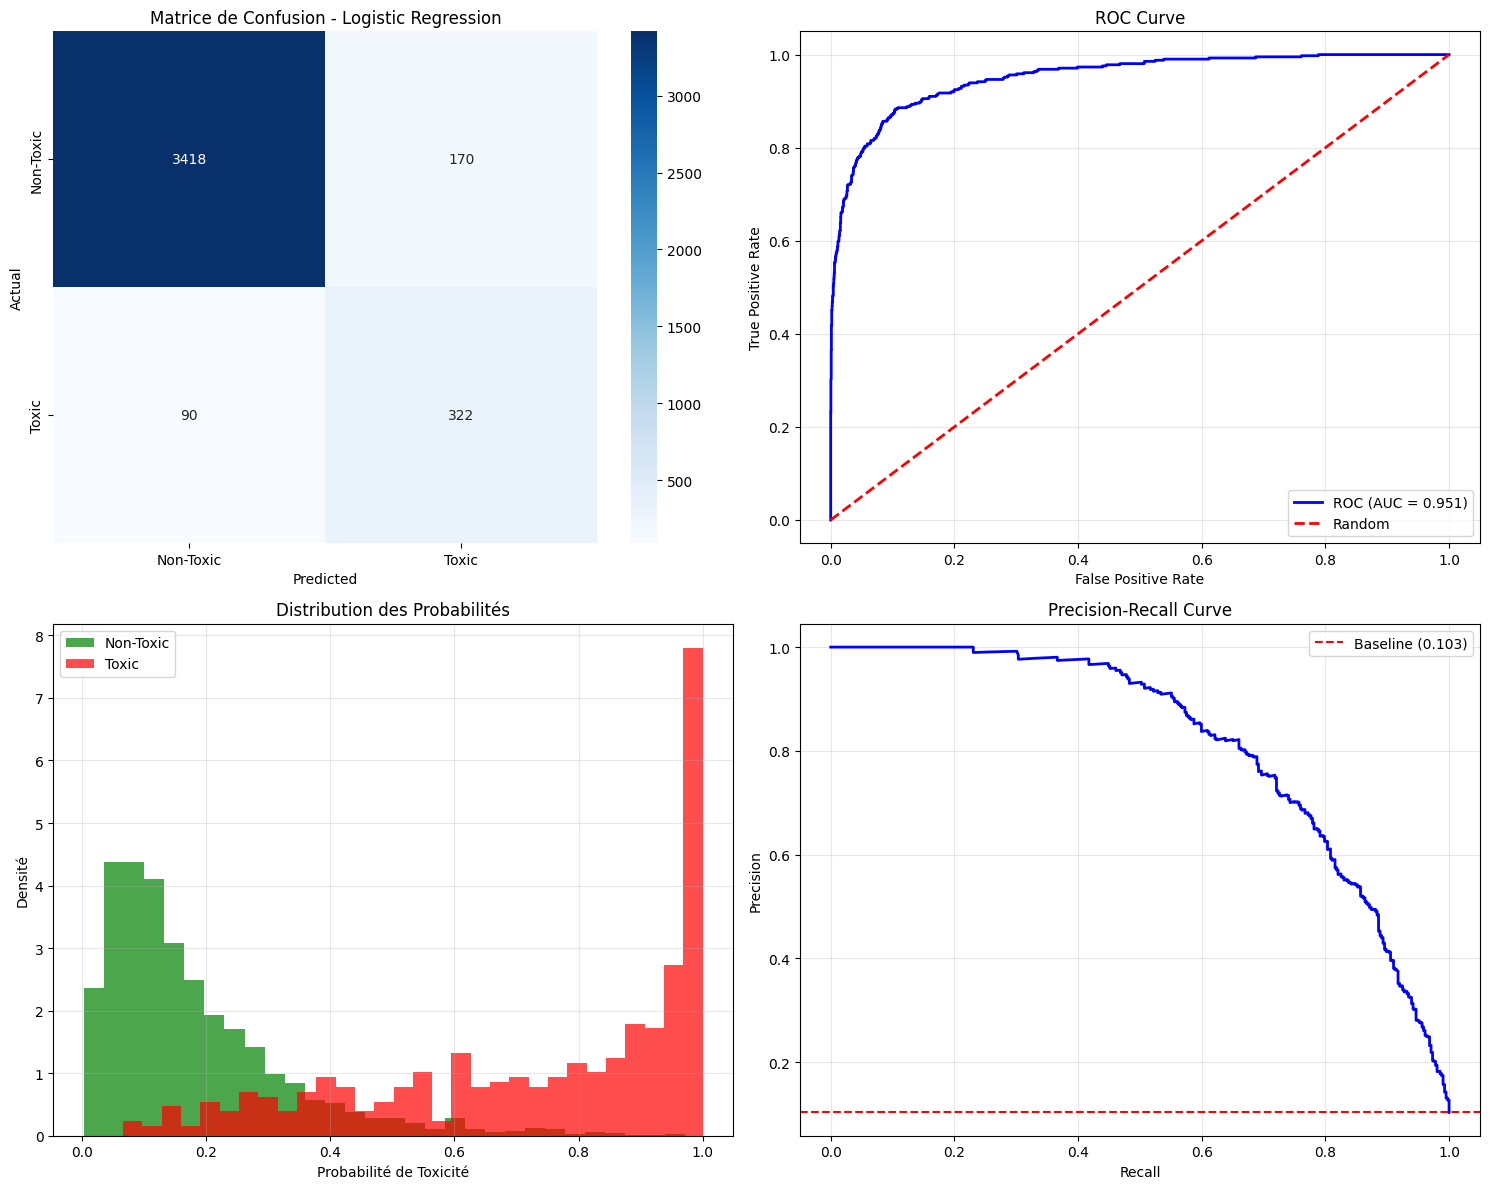

In [13]:
# Visualisations pour le meilleur modèle
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'],
            ax=axes[0,0])
axes[0,0].set_title(f'Matrice de Confusion - {best_model_name}')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

# 2. ROC Curve (si disponible)
if y_pred_proba is not None:
    fpr, tpr, _ = roc_curve(y_val_split, y_pred_proba)
    auc_score = roc_auc_score(y_val_split, y_pred_proba)
    
    axes[0,1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {auc_score:.3f})')
    axes[0,1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curve')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
else:
    axes[0,1].text(0.5, 0.5, 'ROC Curve\nnon disponible', 
                   ha='center', va='center', transform=axes[0,1].transAxes)

# 3. Distribution des probabilités
if y_pred_proba is not None:
    toxic_probs = y_pred_proba[y_val_split == 1]
    non_toxic_probs = y_pred_proba[y_val_split == 0]
    
    axes[1,0].hist(non_toxic_probs, bins=30, alpha=0.7, label='Non-Toxic', color='green', density=True)
    axes[1,0].hist(toxic_probs, bins=30, alpha=0.7, label='Toxic', color='red', density=True)
    axes[1,0].set_xlabel('Probabilité de Toxicité')
    axes[1,0].set_ylabel('Densité')
    axes[1,0].set_title('Distribution des Probabilités')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
else:
    axes[1,0].text(0.5, 0.5, 'Distribution\nnon disponible', 
                   ha='center', va='center', transform=axes[1,0].transAxes)

# 4. Precision-Recall Curve
if y_pred_proba is not None:
    precision, recall, _ = precision_recall_curve(y_val_split, y_pred_proba)
    
    axes[1,1].plot(recall, precision, color='blue', lw=2)
    axes[1,1].set_xlabel('Recall')
    axes[1,1].set_ylabel('Precision')
    axes[1,1].set_title('Precision-Recall Curve')
    axes[1,1].grid(True, alpha=0.3)
    
    # Ligne de base (proportion de positifs)
    baseline = y_val_split.sum() / len(y_val_split)
    axes[1,1].axhline(y=baseline, color='red', linestyle='--', label=f'Baseline ({baseline:.3f})')
    axes[1,1].legend()
else:
    axes[1,1].text(0.5, 0.5, 'Precision-Recall\nnon disponible', 
                   ha='center', va='center', transform=axes[1,1].transAxes)

plt.tight_layout()
plt.show()

## 7. 💾 Sauvegarde du Meilleur Modèle

In [14]:
# Sauvegarder le meilleur modèle et le vectorizer
import os

models_dir = '../models/simple_model'
os.makedirs(models_dir, exist_ok=True)

print(f"💾 Sauvegarde du modèle {best_model_name}...")

# Sauvegarder le modèle
model_path = os.path.join(models_dir, 'best_simple_model.pkl')
joblib.dump(best_model, model_path)
print(f"✅ Modèle sauvegardé: {model_path}")

# Sauvegarder le vectorizer TF-IDF
vectorizer_path = os.path.join(models_dir, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf, vectorizer_path)
print(f"✅ Vectorizer sauvegardé: {vectorizer_path}")

# Sauvegarder les métadonnées
metadata = {
    'model_name': best_model_name,
    'model_type': 'simple_tfidf',
    'f1_score': best_results['f1_score'],
    'accuracy': best_results['accuracy'],
    'auc_roc': best_results['auc_roc'],
    'train_time': best_results['train_time'],
    'inference_time_per_text_ms': best_results['inference_time']/len(y_val_split)*1000,
    'vocabulary_size': len(tfidf.vocabulary_),
    'training_samples': len(X_train_split),
    'validation_samples': len(X_val_split),
    'created_at': datetime.now().isoformat(),
    'criteria_met': {
        'f1_above_075': best_results['f1_score'] > 0.75,
        'inference_below_500ms': (best_results['inference_time']/len(y_val_split)*1000) < 500
    }
}

metadata_path = os.path.join(models_dir, 'metadata.json')
import json
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Métadonnées sauvegardées: {metadata_path}")

# Sauvegarder les résultats de comparaison
comparison_path = os.path.join(models_dir, 'model_comparison.csv')
comparison_df.to_csv(comparison_path, index=False)
print(f"✅ Comparaison sauvegardée: {comparison_path}")

print(f"\n🎉 MODÈLE SIMPLE ENTRAÎNÉ ET SAUVEGARDÉ !")
print(f"📁 Dossier: {models_dir}")
print(f"🏆 Meilleur modèle: {best_model_name}")
print(f"📊 F1-Score: {best_results['f1_score']:.4f}")
print(f"⚡ Temps inférence: {metadata['inference_time_per_text_ms']:.2f}ms/texte")

💾 Sauvegarde du modèle Logistic Regression...
✅ Modèle sauvegardé: ../models/simple_model\best_simple_model.pkl
✅ Vectorizer sauvegardé: ../models/simple_model\tfidf_vectorizer.pkl
✅ Métadonnées sauvegardées: ../models/simple_model\metadata.json
✅ Comparaison sauvegardée: ../models/simple_model\model_comparison.csv

🎉 MODÈLE SIMPLE ENTRAÎNÉ ET SAUVEGARDÉ !
📁 Dossier: ../models/simple_model
🏆 Meilleur modèle: Logistic Regression
📊 F1-Score: 0.7124
⚡ Temps inférence: 0.00ms/texte
✅ Vectorizer sauvegardé: ../models/simple_model\tfidf_vectorizer.pkl
✅ Métadonnées sauvegardées: ../models/simple_model\metadata.json
✅ Comparaison sauvegardée: ../models/simple_model\model_comparison.csv

🎉 MODÈLE SIMPLE ENTRAÎNÉ ET SAUVEGARDÉ !
📁 Dossier: ../models/simple_model
🏆 Meilleur modèle: Logistic Regression
📊 F1-Score: 0.7124
⚡ Temps inférence: 0.00ms/texte


## 8. 🧪 Test de Prédiction

Testons notre modèle sur quelques exemples

In [15]:
# Fonction de prédiction
def predict_toxicity(text, model, vectorizer):
    """Prédit la toxicité d'un texte"""
    # Préprocessing simple (similaire à comment_clean)
    import re
    
    text_clean = str(text).lower()
    text_clean = re.sub(r'http\S+|www\S+|https\S+', '', text_clean, flags=re.MULTILINE)
    text_clean = re.sub(r'@\w+', '', text_clean)
    text_clean = re.sub(r'#\w+', '', text_clean)
    text_clean = re.sub(r'[^a-zA-Z\s]', ' ', text_clean)
    text_clean = re.sub(r'\s+', ' ', text_clean).strip()
    
    # Vectorisation
    text_tfidf = vectorizer.transform([text_clean])
    
    # Prédiction
    prediction = model.predict(text_tfidf)[0]
    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(text_tfidf)[0, 1]
        return prediction, probability
    else:
        return prediction, None

# Tests sur des exemples
test_texts = [
    "This is a great article, thank you for sharing!",
    "You are stupid and I hate you",
    "I disagree with your opinion but respect your right to have it",
    "This movie is terrible and boring",
    "Kill yourself, nobody likes you",
    "I love this community, everyone is so helpful"
]

print("🧪 TESTS DE PRÉDICTION")
print("=" * 80)

for i, text in enumerate(test_texts, 1):
    pred, prob = predict_toxicity(text, best_model, tfidf)
    prob_text = f" (prob: {prob:.3f})" if prob is not None else ""
    status = "🔴 TOXIC" if pred == 1 else "🟢 NON-TOXIC"
    
    print(f"\n{i}. \"{text}\"")
    print(f"   → {status}{prob_text}")

🧪 TESTS DE PRÉDICTION

1. "This is a great article, thank you for sharing!"
   → 🟢 NON-TOXIC (prob: 0.084)

2. "You are stupid and I hate you"
   → 🔴 TOXIC (prob: 0.999)

3. "I disagree with your opinion but respect your right to have it"
   → 🟢 NON-TOXIC (prob: 0.158)

4. "This movie is terrible and boring"
   → 🟢 NON-TOXIC (prob: 0.213)

5. "Kill yourself, nobody likes you"
   → 🔴 TOXIC (prob: 0.940)

6. "I love this community, everyone is so helpful"
   → 🟢 NON-TOXIC (prob: 0.194)

1. "This is a great article, thank you for sharing!"
   → 🟢 NON-TOXIC (prob: 0.084)

2. "You are stupid and I hate you"
   → 🔴 TOXIC (prob: 0.999)

3. "I disagree with your opinion but respect your right to have it"
   → 🟢 NON-TOXIC (prob: 0.158)

4. "This movie is terrible and boring"
   → 🟢 NON-TOXIC (prob: 0.213)

5. "Kill yourself, nobody likes you"
   → 🔴 TOXIC (prob: 0.940)

6. "I love this community, everyone is so helpful"
   → 🟢 NON-TOXIC (prob: 0.194)


## 📋 Résumé - Modèle Simple

### ✅ Étapes réalisées :
1. **Vectorisation TF-IDF** avec 10k features max
2. **Entraînement** de 3 modèles (Logistic Regression, Naive Bayes, Random Forest)
3. **Évaluation** complète avec métriques de performance
4. **Sauvegarde** du meilleur modèle
5. **Tests** sur exemples concrets

### 🎯 Prochaines étapes :
1. **Modèle BERT** : Fine-tuning pour comparaison
2. **Optimisation** : Hyperparameter tuning
3. **Production** : Export pour API

### 📁 Fichiers générés :
- `models/simple_model/best_simple_model.pkl` : Modèle entraîné
- `models/simple_model/tfidf_vectorizer.pkl` : Vectorizer TF-IDF
- `models/simple_model/metadata.json` : Métadonnées et performances